## Current Python Version

Ensure the python version running in the jupyter kernel is the same as expected

In [1]:
# from platform import python_version

# print(python_version())


List installed packages, should match the ones in the pipfile (and their dependencies)

In [2]:
# pip list

## Internal Module Imports
Code required to enable project's internally defined modulos into the jupyter notebook environment

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from electricity import ElectricalSystem, Load, Generator
from dto import (
    COST_PRESETS, 
    ElectricalSystemSpecs, 
    EpsilonSpecs,
    GeneratorSpecs, 
    LoadSpecs, 
    NodeStatePower, 
    SystemHistory, 
    )
    
from learning import ModelTrainer, ModelTester, LearningParams

/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmello/.local/share/virtualenvs/2019-MSc_Thesis-4pUnri4s/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

Determine the experiment params

In [5]:
from dto import EpsilonSpecs, ElectricalConstants
import math

LearningParams(
    gamma=0.9,   # Gamma (Discount)
    tau=0.001, # Tau
    epsilonSpecs = EpsilonSpecs( # Epsilon explore/exploit control
        thresholdProgress = 0.6, # % of steps where decay change should happen
        thresholdValue = 0.5, # Value at which decay change would happen
        finalValue = 0.0001, # Value at the end of the experiment
    ),
    numEpisodes=2000, # Number of learning episodes to run
    maxSteps=100,   # Number of steps per learning episode
    bufferSize=500, # Experience Buffer Size
    traceLength=15,     # Number of steps each sampled episode should contain
    batchSize=40,     # Number of episodes sampled from experience buffer
    updateInterval=4, # Run update cycle every N steps
    electricalSystemSpecs = ElectricalSystemSpecs(
        loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.05)],
        generators=[
            GeneratorSpecs(id_="G1", basePower=2, costProfile=COST_PRESETS.COAL_OLD, minPower=0.5, maxPower=5.0, noiseLevel=0.1),
            GeneratorSpecs(id_="G2", basePower=2, costProfile=COST_PRESETS.OIL_OLD, minPower=0.5, maxPower=5.0, noiseLevel=0.1),
#             GeneratorSpecs(id_="G3", basePower=1.0, costProfile=COST_PRESETS.OIL_ALTERNATE_2, minPower=0.5, maxPower=5.0, noiseLevel=0.05),
        ],
        shouldTrackOptimalCost=True,
    ),
    modelName='2Gen-OriginalTest-C65-2k'
)

# Droop = +infinity essentially remove the droop component from the power update equation. System reacts as if droop is disabled
# ElectricalConstants().droop = math.inf

LearningParams(electricalSystemSpecs=ElectricalSystemSpecs(loads=[LoadSpecs(id_='L1', basePower=3.0, noiseLevel=0.05)], generators=[GeneratorSpecs(id_='G1', basePower=2, costProfile=CostProfile(alpha=0.0, beta=0, gamma=1), minPower=0.5, maxPower=5.0, noiseLevel=0.1), GeneratorSpecs(id_='G2', basePower=2, costProfile=CostProfile(alpha=0.0, beta=0, gamma=2), minPower=0.5, maxPower=5.0, noiseLevel=0.1)], shouldTrackOptimalCost=True), gamma=0.9, tau=0.001, epsilonSpecs=EpsilonSpecs(thresholdProgress=0.6, thresholdValue=0.5, finalValue=0.0001), numEpisodes=2000, maxSteps=100, bufferSize=500, traceLength=15, batchSize=40, updateInterval=4, nnShape=NeuralNetworkShape(layer_00_ltsm=100, layer_01_mlp_01=1000, layer_02_mlp_02=100, layer_03_mlp_03=50, layer_04_mlp_04=1), modelName='2Gen-OriginalTest-C65-2k')

Train Agents

In [18]:
def rewardFn(totalCost, outputDifferential):
    # Original cost
    scaledCost = totalCost/(10000*100.0)
    # New costs
#     scaledCost = totalCost/(100000.0) # Scale down cost to levels near the ones found in output differential (e.g. 0.1 */ 0.01) 
    costComponent = 2**(-1*(scaledCost**2)*200)
    outputComponent = 2**(-1*(outputDifferential**2)*500)
    earnedReward = costComponent*outputComponent
    
    print(f'Scaled_Cost:{scaledCost} - OutputDiff:{outputDifferential} - costComponent:{costComponent} - outputComponent:{outputComponent} - reward:{earnedReward}')

    return earnedReward, {'cost': costComponent, 'output': outputComponent, 'total':earnedReward}

In [19]:
from learning.cost import ModelAdapterCost as ModelAdapter
modelAdapter = ModelAdapter(rewardFn=rewardFn)

In [8]:
%%time
allAgents = ModelTrainer(modelAdapter).trainAgents()

W0918 16:17:43.942000 140389653481216 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0918 16:17:43.942891 140389653481216 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:29: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0918 16:17:43.959809 140389653481216 deprecation.py:323] From /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/learning/actor.py:38: dyna

Training model: 2Gen-OriginalTest-C65-2k - 0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100%
Model saved in path: /mnt/c/Users/flavi/Documents/Study/City-UniLondon/Thesis/2019-MSc_Thesis/app/models/2Gen-OriginalTest-C65-2k/model
CPU times: user 4h 47min 24s, sys: 47min 45s, total: 5h 35min 10s
Wall time: 1h 46min 25s


In [20]:
STEPS_TO_TEST = 300

# testSpecs = ElectricalSystemSpecs(
#         loads=[LoadSpecs(id_="L1", basePower=3.0, noiseLevel=0.1)],
#         generators=[
#             GeneratorSpecs(id_="G1", basePower=1.5, costProfile=COST_PRESETS.COAL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#             GeneratorSpecs(id_="G2", basePower=1.5, costProfile=COST_PRESETS.OIL, minPower=0.5, maxPower=2.0, noiseLevel=0.0),
#         ],
# )
# electricalSystem, rewards = ModelTester.testAgents(testSpecs, LearningParams().modelName, STEPS_TO_TEST)


electricalSystem, rewards = ModelTester(modelAdapter).testAgents(LearningParams().electricalSystemSpecs, LearningParams().modelName, STEPS_TO_TEST)

Scaled_Cost:0.11424532474094862 - OutputDiff:-3.8158789487903885e-09 - costComponent:0.16375389809799243 - outputComponent:0.999999999999995 - reward:0.16375389809799162
Scaled_Cost:0.11065949521601356 - OutputDiff:-3.8158789487903885e-09 - costComponent:0.18312430936875063 - outputComponent:0.999999999999995 - reward:0.1831243093687497
Scaled_Cost:0.107673659284408 - OutputDiff:-4.197466843669427e-08 - costComponent:0.20044476151536547 - outputComponent:0.9999999999993894 - reward:0.20044476151524307
Scaled_Cost:0.10528453448047544 - OutputDiff:-1.8745505335932785e-05 - costComponent:0.21509313125473228 - outputComponent:0.9999998782161376 - reward:0.21509310505985998
Scaled_Cost:0.10214318312257568 - OutputDiff:-0.008485856542991157 - costComponent:0.23542738145070896 - outputComponent:0.9753521619078672 - reward:0.2296246054702571
Scaled_Cost:0.10478928159566148 - OutputDiff:-0.00414351413121248 - costComponent:0.21821789082928525 - outputComponent:0.9940674462653569 - reward:0.2169

Scaled_Cost:0.09998035520192285 - OutputDiff:-0.013515014475406366 - costComponent:0.25013619107164575 - outputComponent:0.938658441783091 - reward:0.2347924473448685
Scaled_Cost:0.10825719911590288 - OutputDiff:0.028547575628146988 - costComponent:0.19697381597406807 - outputComponent:0.7539380884456813 - reward:0.1485060622893403
Scaled_Cost:0.09953721505495636 - OutputDiff:-0.016063973914711486 - costComponent:0.2532209305121382 - outputComponent:0.9144488444958684 - reward:0.23155758730899334
Scaled_Cost:0.09942764457575197 - OutputDiff:-0.02247218167499947 - costComponent:0.25398737627726753 - outputComponent:0.839440820308537 - reward:0.2132073714902025
Scaled_Cost:0.1001747593988239 - OutputDiff:-0.012893196967336491 - costComponent:0.24879053676194757 - outputComponent:0.9440156852810884 - reward:0.23486216905277973
Scaled_Cost:0.10692388545531048 - OutputDiff:0.022551917804528525 - costComponent:0.20496600356313724 - outputComponent:0.8383970244107043 - reward:0.17184288749268

Scaled_Cost:0.09864055293210773 - OutputDiff:-0.01979795742347267 - costComponent:0.2595363042001241 - outputComponent:0.872979959925931 - reward:0.22656999243994858
Scaled_Cost:0.10784149347045088 - OutputDiff:0.026776541304706757 - costComponent:0.19944217926916627 - outputComponent:0.7799796655844274 - reward:0.15556084428979372
Scaled_Cost:0.09841243341941494 - OutputDiff:-0.021106994696855213 - costComponent:0.2611586854203292 - outputComponent:0.8569288848242123 - reward:0.22379442105939998
Scaled_Cost:0.09969448854866682 - OutputDiff:-0.020821143388922377 - costComponent:0.2521233759024044 - outputComponent:0.8604957631716046 - reward:0.21695109676054083
Scaled_Cost:0.09860071293262558 - OutputDiff:-0.019971898541534857 - costComponent:0.2598191874622497 - outputComponent:0.870889530468184 - reward:0.2262738101756237
Scaled_Cost:0.10778821806109898 - OutputDiff:0.026536198169117196 - costComponent:0.19976005233229369 - outputComponent:0.7834510773069547 - reward:0.15650222820262

Scaled_Cost:0.09803705760155698 - OutputDiff:-0.022873885929726796 - costComponent:0.26384216866616256 - outputComponent:0.8341580532020048 - reward:0.22008606976716114
Scaled_Cost:0.0992498412083397 - OutputDiff:-0.022852736420653125 - costComponent:0.2552342430852371 - outputComponent:0.8344376846485833 - reward:0.21297707084307893
Scaled_Cost:0.09824819917686242 - OutputDiff:-0.021634730755472925 - costComponent:0.26233064792177163 - outputComponent:0.8502560152193795 - reward:0.22304821137188355
Scaled_Cost:0.10737961441737782 - OutputDiff:0.024675781651150235 - costComponent:0.20220963992913898 - outputComponent:0.8097524874773058 - reward:0.16373975892451062
Scaled_Cost:0.0980314477908919 - OutputDiff:-0.02290008957046814 - costComponent:0.2638824022591061 - outputComponent:0.8338113691869738 - reward:0.22002814713201305
Scaled_Cost:0.09924794299845681 - OutputDiff:-0.022860841347540354 - costComponent:0.25524757540229137 - outputComponent:0.8343305436213595 - reward:0.2129608483

Scaled_Cost:0.1073985758643369 - OutputDiff:0.024762144531458734 - costComponent:0.20209551083297284 - outputComponent:0.8085551575464595 - reward:0.16340536760098656
Scaled_Cost:0.09804788623868514 - OutputDiff:-0.022822783678844594 - costComponent:0.2637645164604583 - outputComponent:0.8348334269028553 - reward:0.22019943517205898
Scaled_Cost:0.09926699581233261 - OutputDiff:-0.02277431056855811 - costComponent:0.25511377557630277 - outputComponent:0.8354731612922758 - reward:0.21314071256994185
Scaled_Cost:0.09826283498772391 - OutputDiff:-0.021565705321168256 - costComponent:0.2622260744222136 - outputComponent:0.8511351731313663 - reward:0.2231898352529093
Scaled_Cost:0.10739909327511733 - OutputDiff:0.02476450846846751 - costComponent:0.20209239715413357 - outputComponent:0.8085223501939245 - reward:0.16339621990338404
Scaled_Cost:0.09804892371263586 - OutputDiff:-0.022817887906153297 - costComponent:0.26375707747974203 - outputComponent:0.834898079411831 - reward:0.2202102774191

Scaled_Cost:0.09804811277938046 - OutputDiff:-0.02282169615334419 - costComponent:0.26376289208861825 - outputComponent:0.8348477892937461 - reward:0.22020186735790787
Scaled_Cost:0.09926686047002178 - OutputDiff:-0.022774903937734646 - costComponent:0.25511472587107786 - outputComponent:0.835465335437057 - reward:0.2131395100248129
Scaled_Cost:0.09826276497576132 - OutputDiff:-0.021566025854999955 - costComponent:0.26222657459853393 - outputComponent:0.8511310949763682 - reward:0.22318919156995248
Scaled_Cost:0.10739859318425432 - OutputDiff:0.024762236112553505 - costComponent:0.20209540660449837 - outputComponent:0.8085538865929651 - reward:0.16340502647265276
Scaled_Cost:0.09804826953982752 - OutputDiff:-0.022820961596646545 - costComponent:0.2637617680679359 - outputComponent:0.8348574899594429 - reward:0.2202034876364617
Scaled_Cost:0.09926696061142144 - OutputDiff:-0.022774442216381842 - costComponent:0.2551140227363559 - outputComponent:0.8354714250205577 - reward:0.21314047611

Alternatively, one can plot the data to better inspect the progression

In [10]:
import matplotlib.pyplot as plt
from learning.learning_state import LearningState
from plots import plotAll, plotExperimentRewardProgression

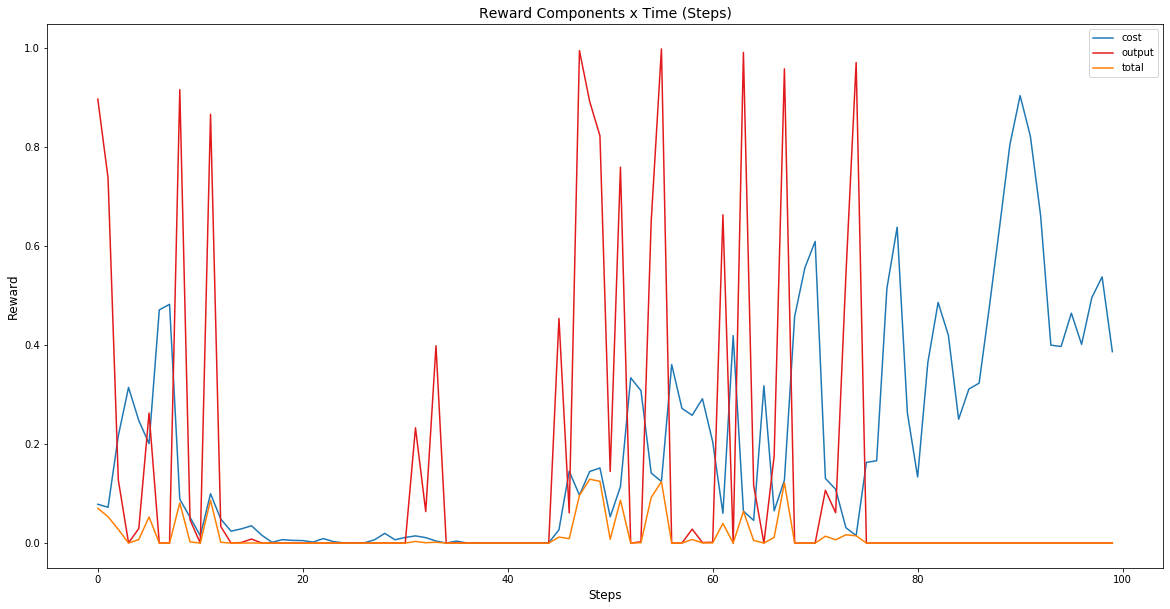

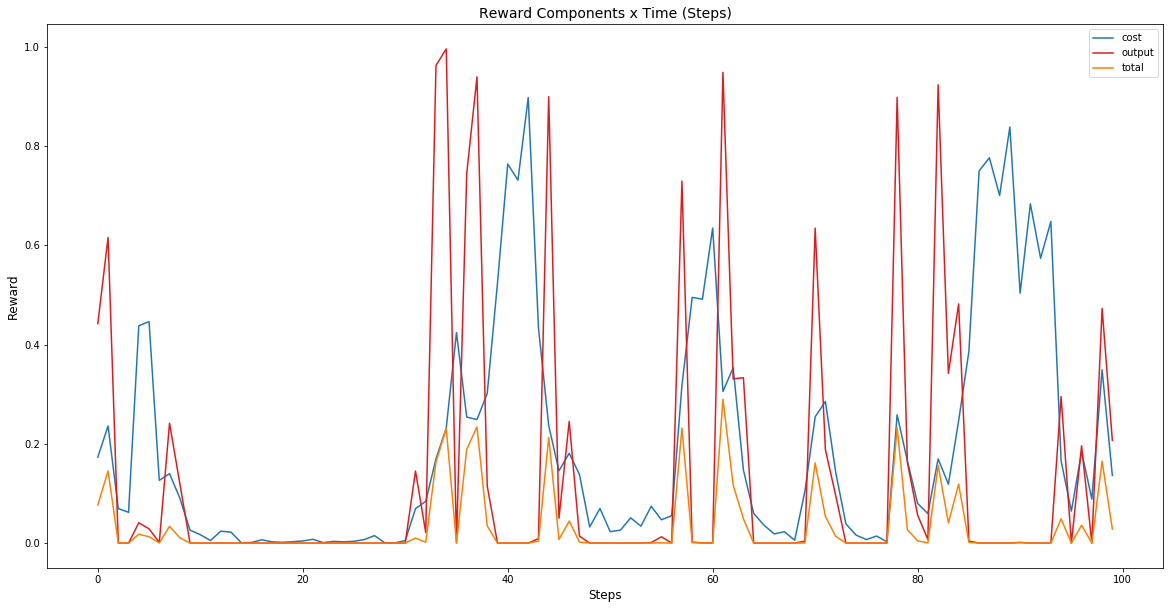

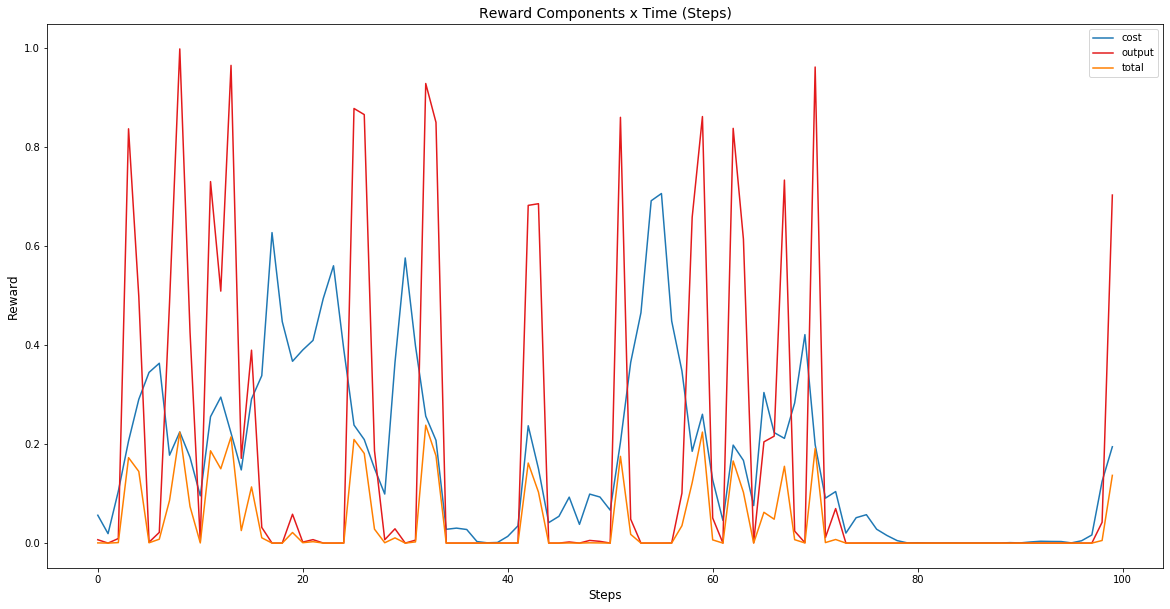

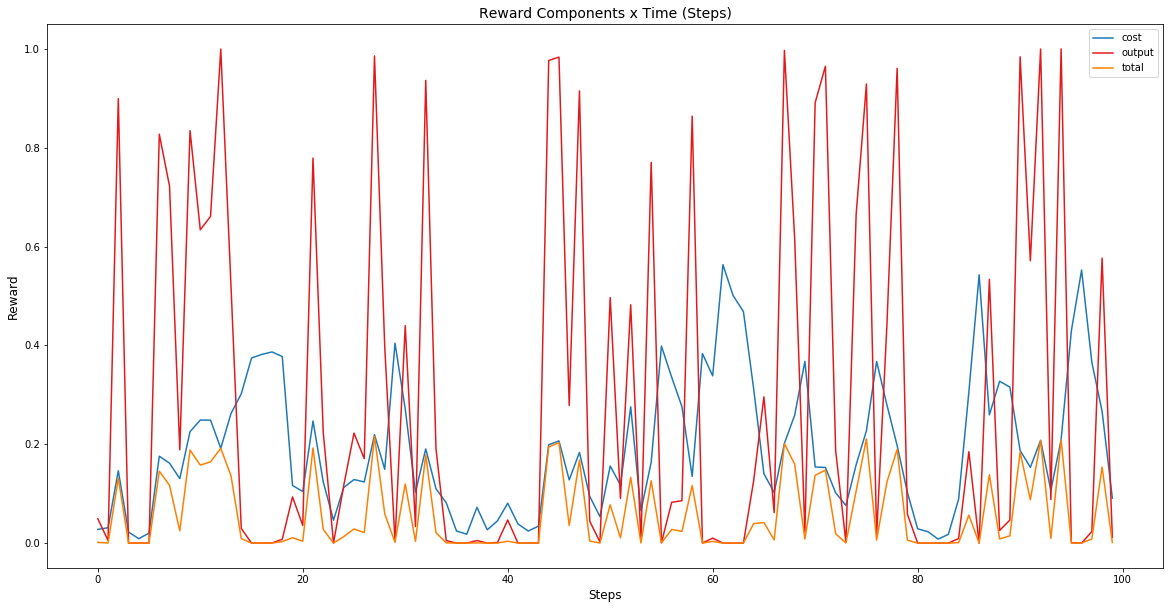

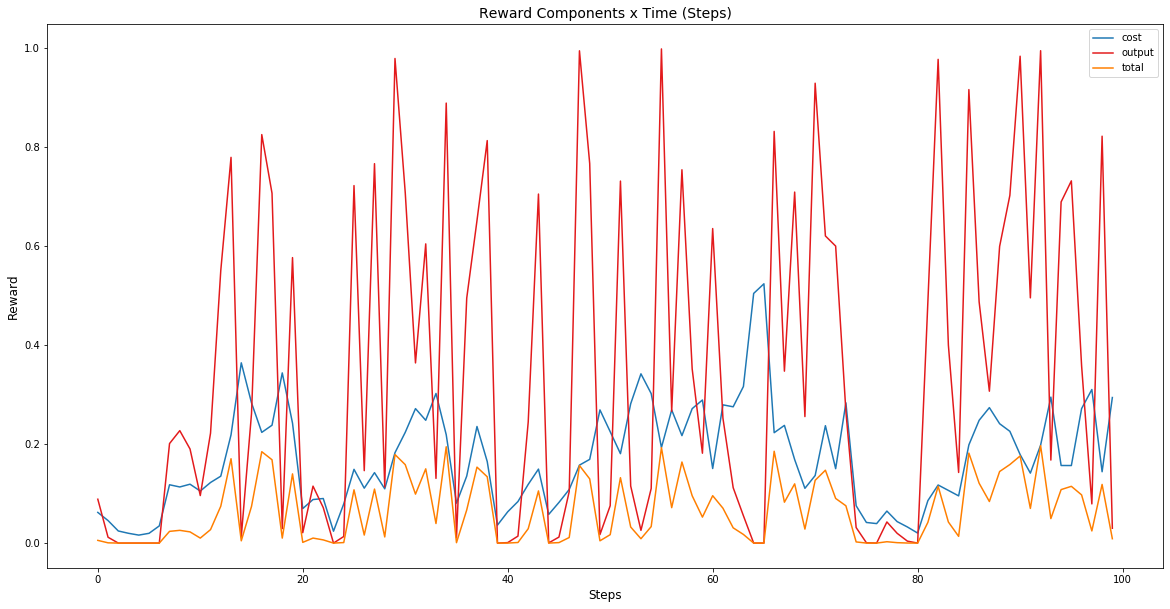

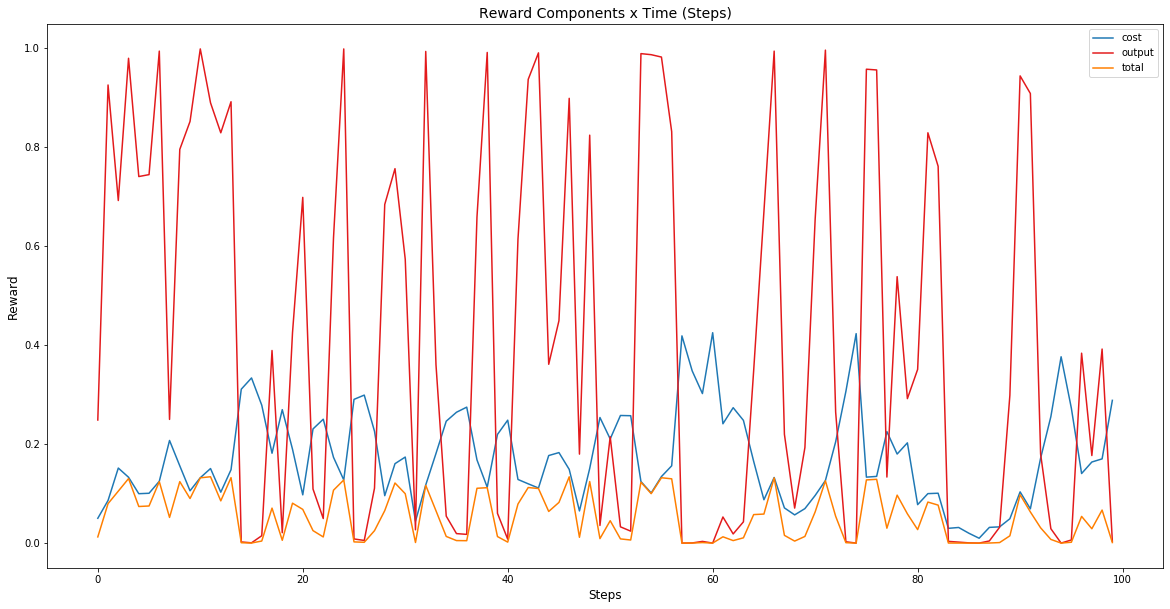

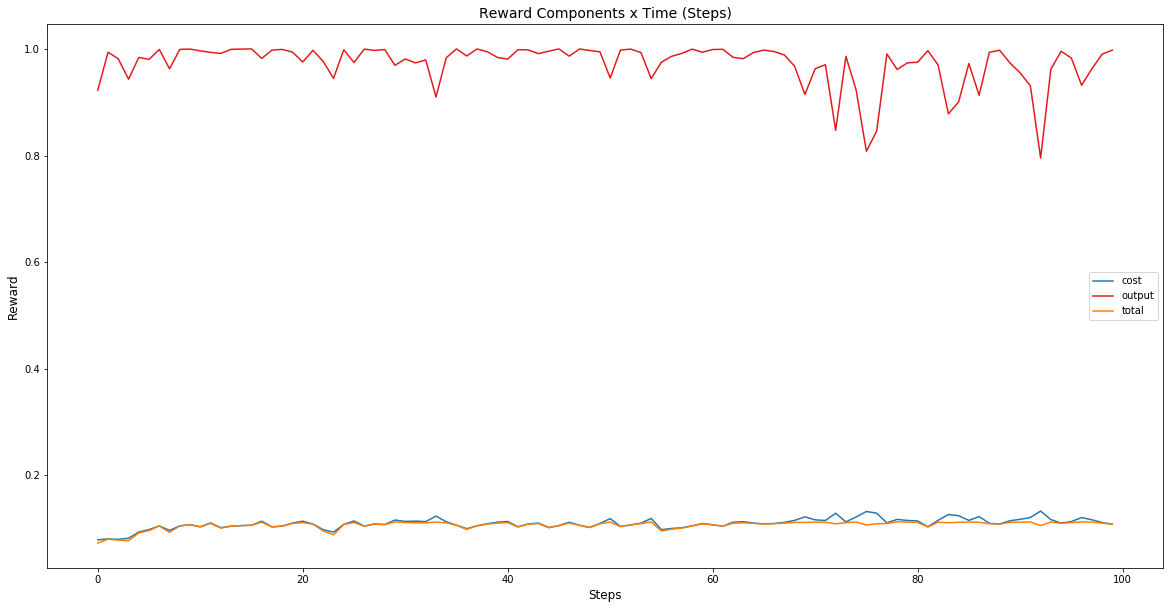

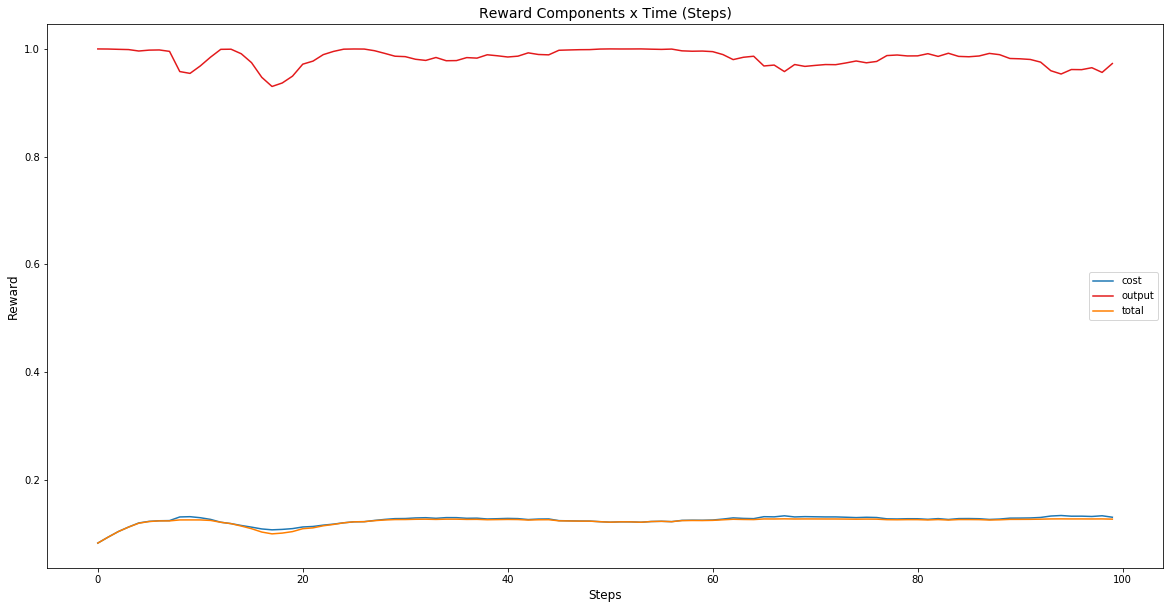

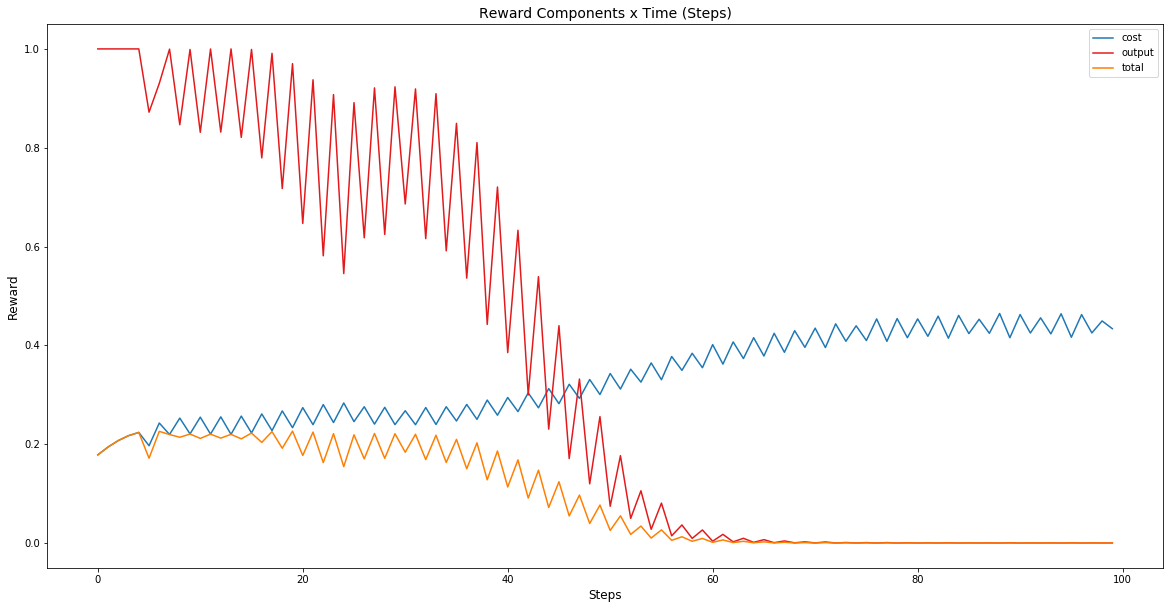

In [11]:
plotExperimentRewardProgression(LearningState().model.allRewards)

Plot the reward progression of the model testing

55.84534328515329

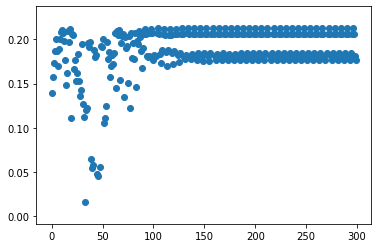

In [12]:
steps = range(STEPS_TO_TEST)
plt.scatter(steps, rewards)
sum(rewards)

Plot all graphs related to the electrical system state during the model testing

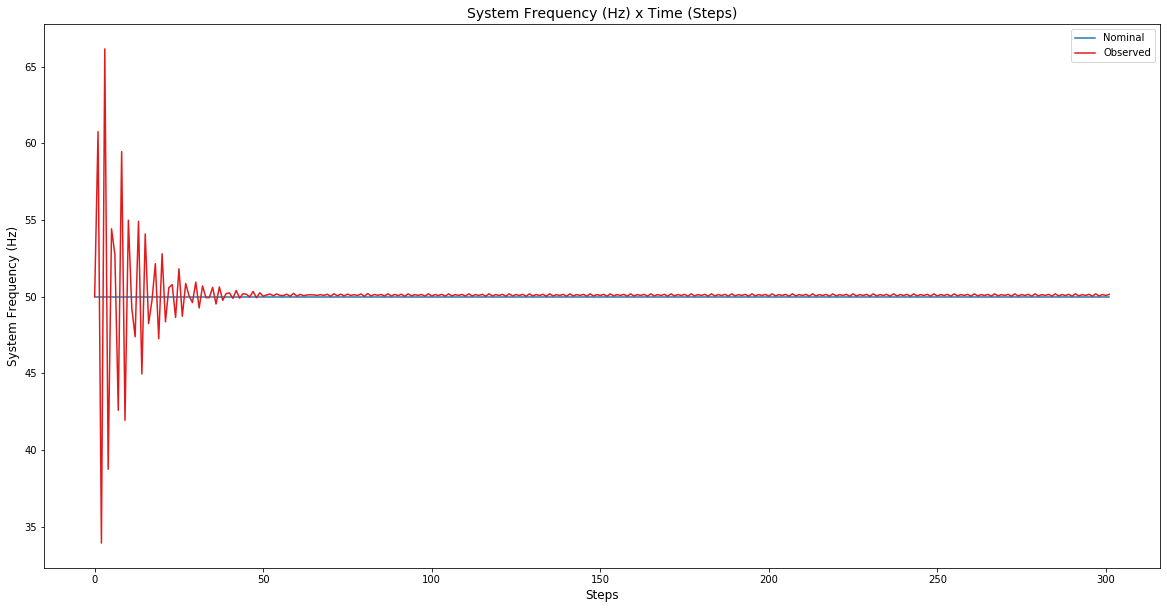

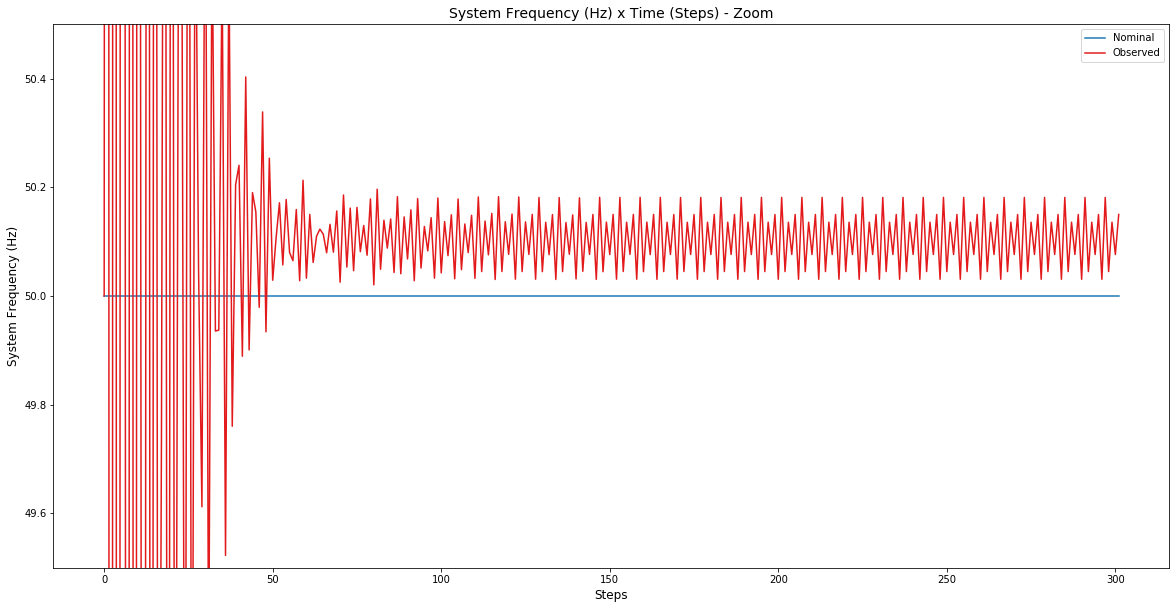

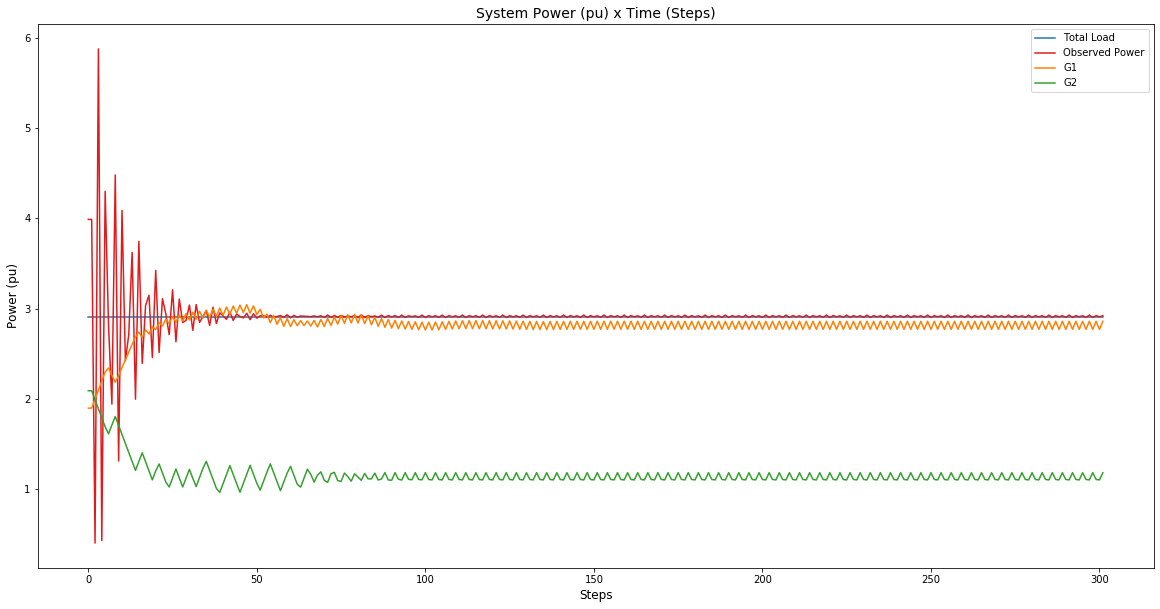

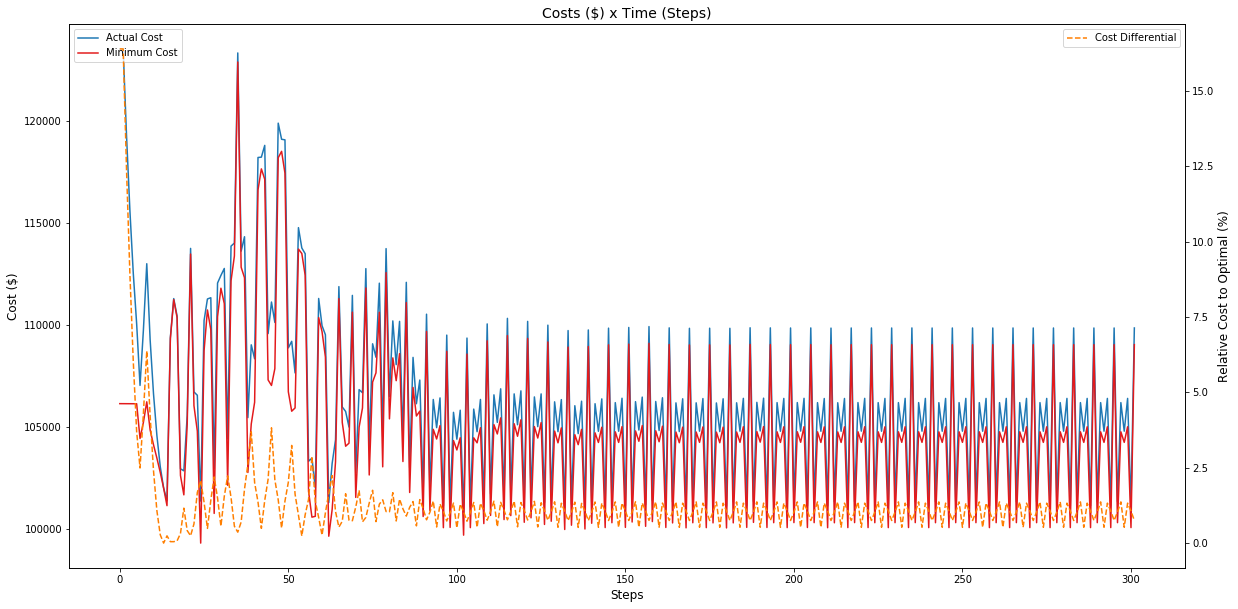

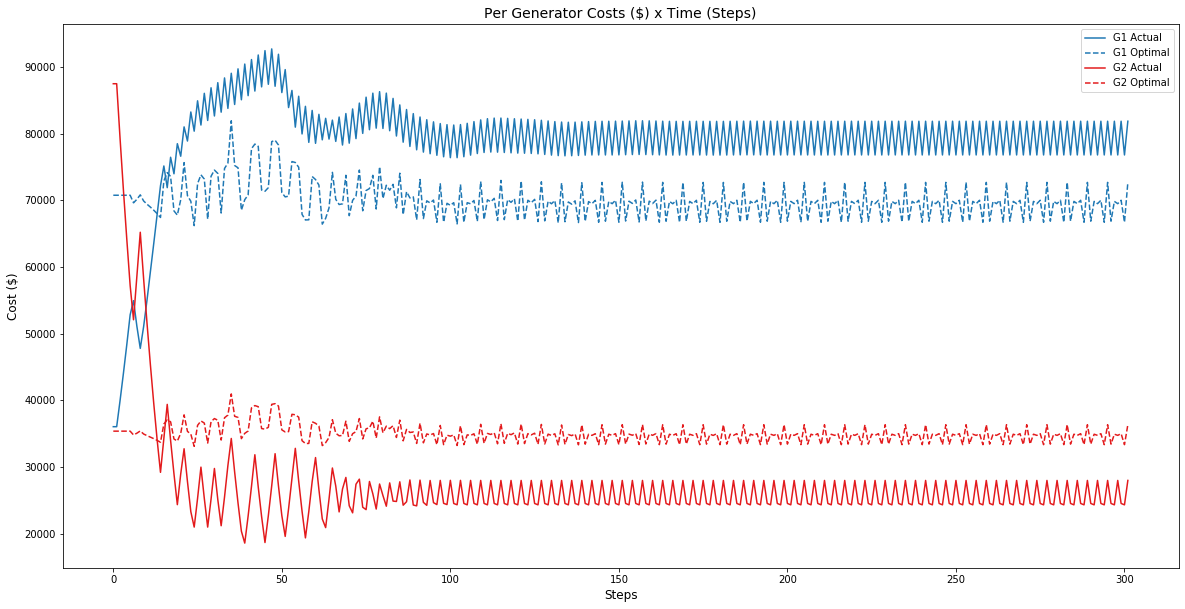

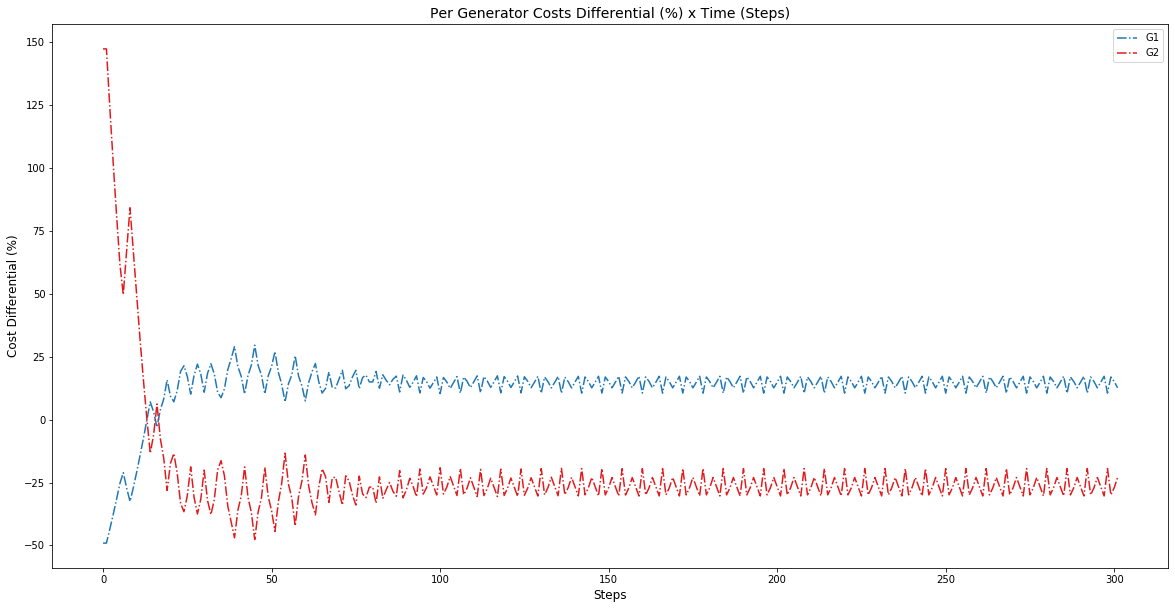

In [13]:
plotAll(electricalSystem.systemHistory)

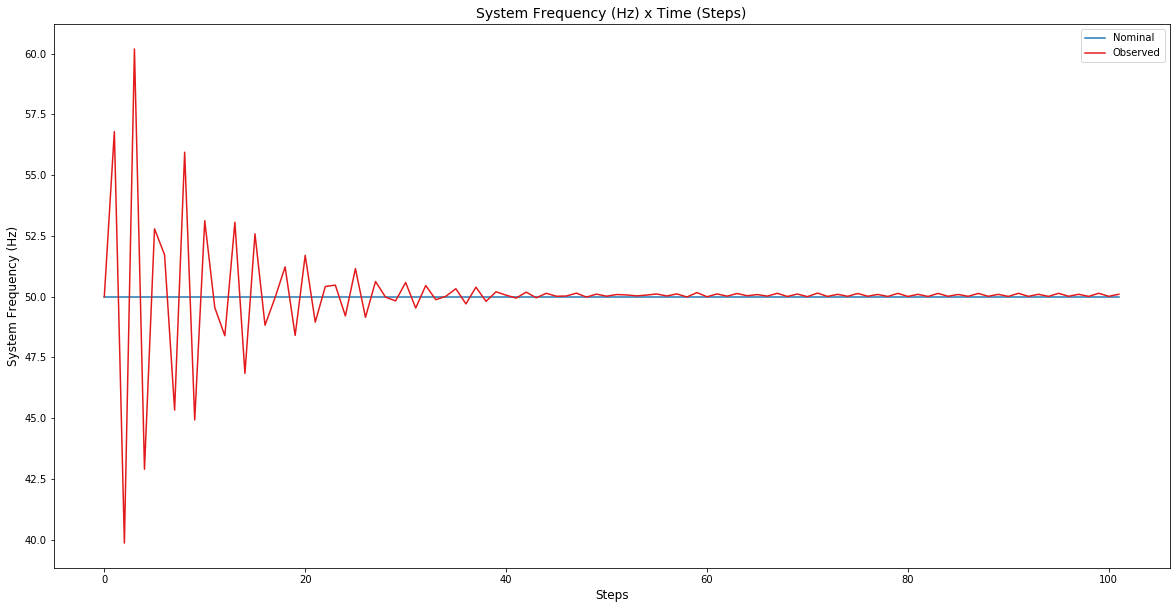

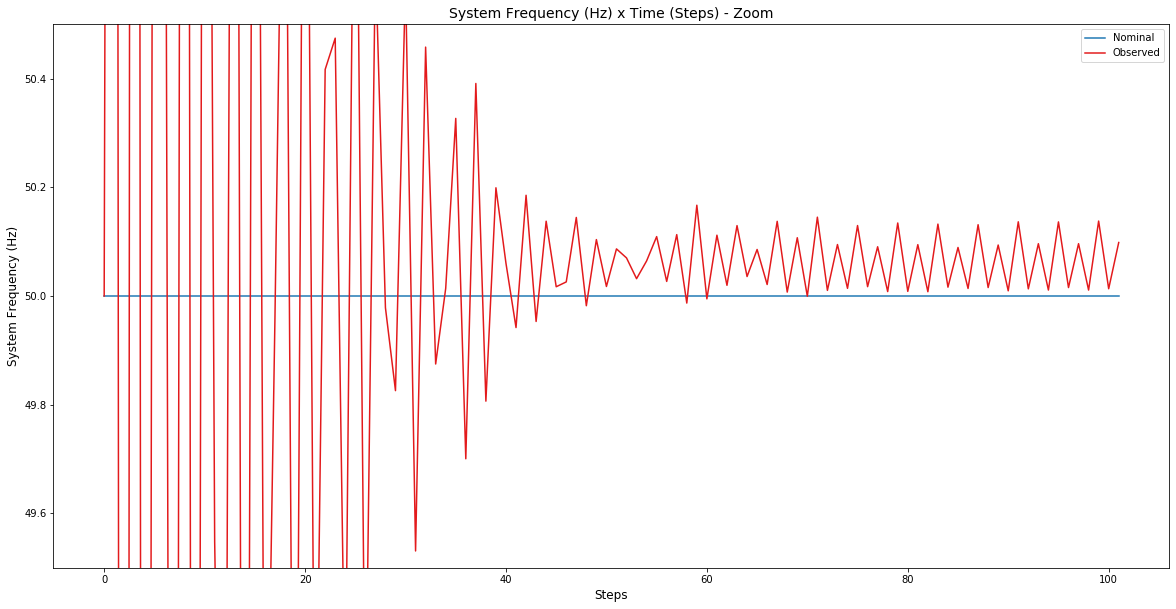

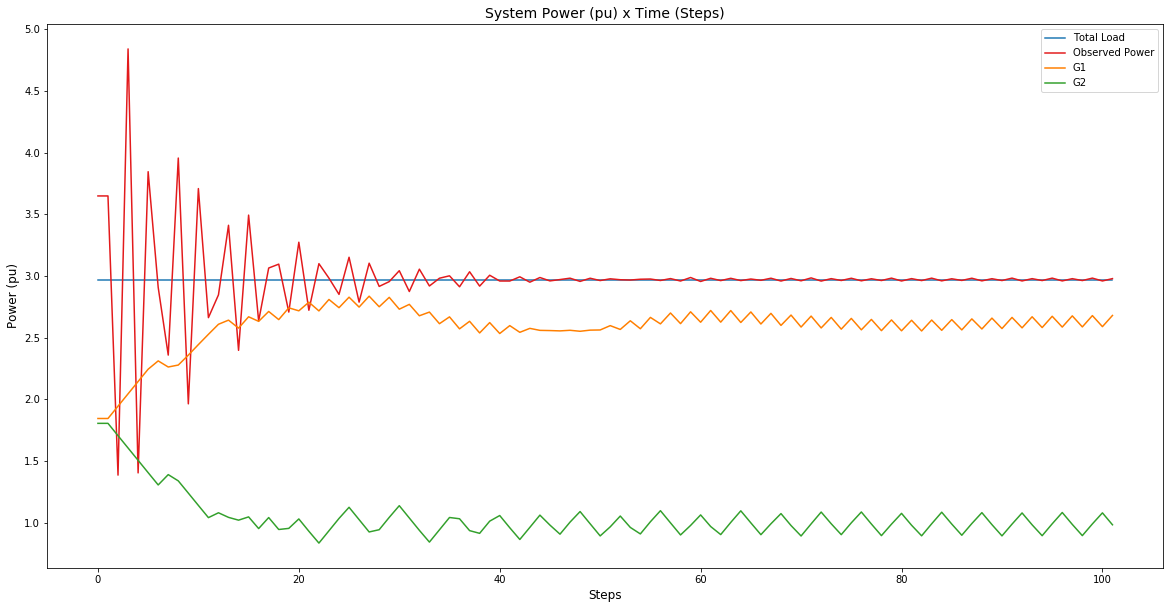

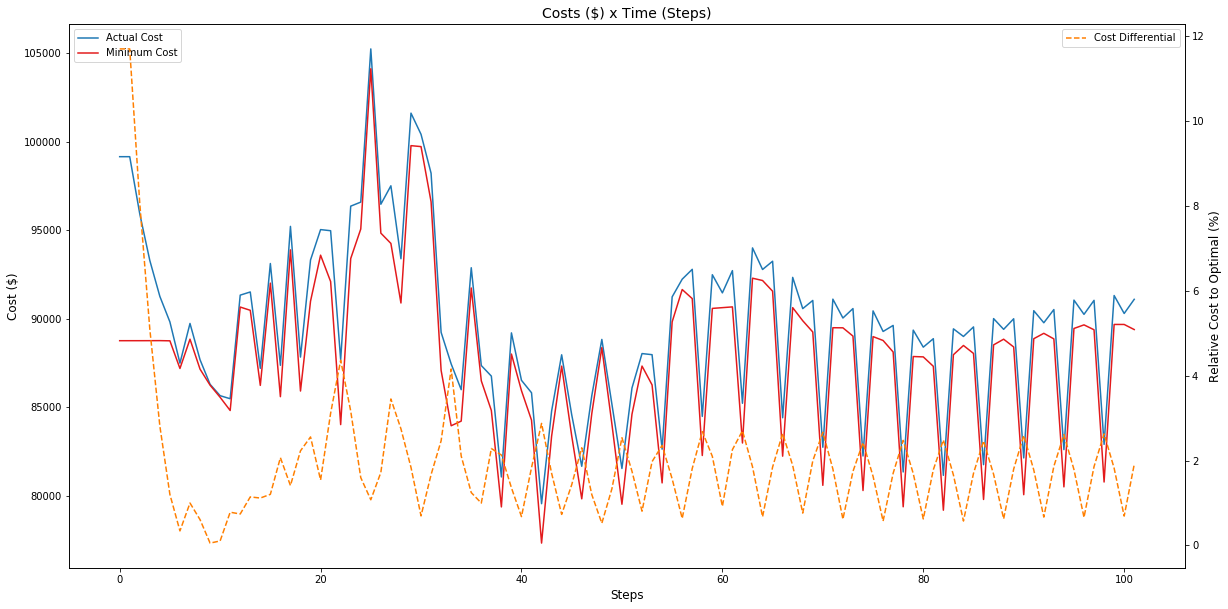

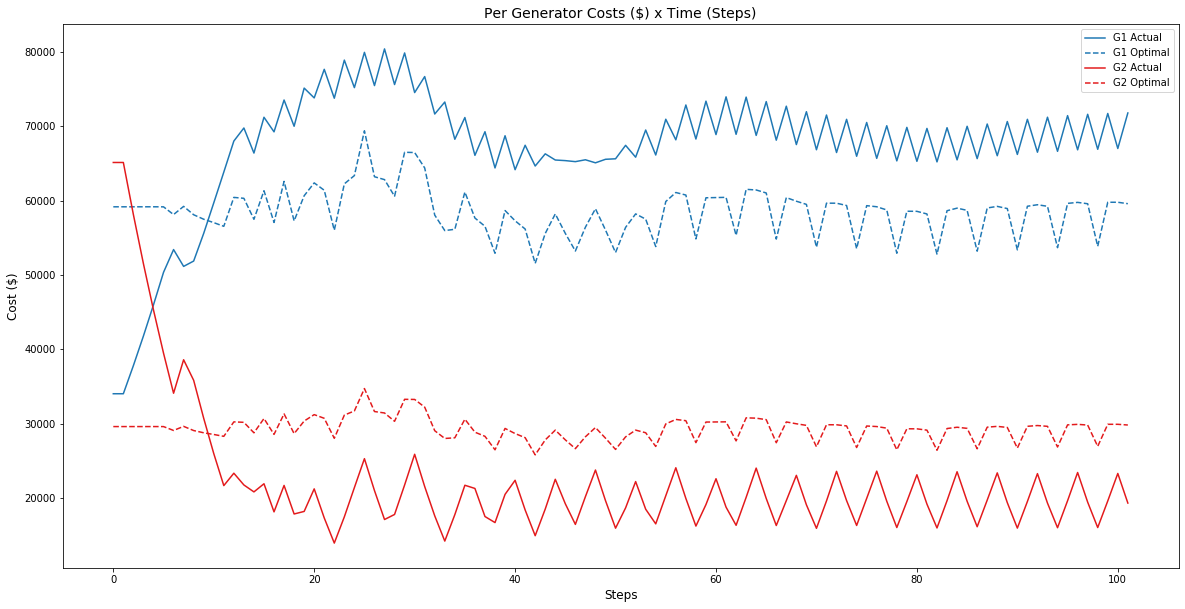

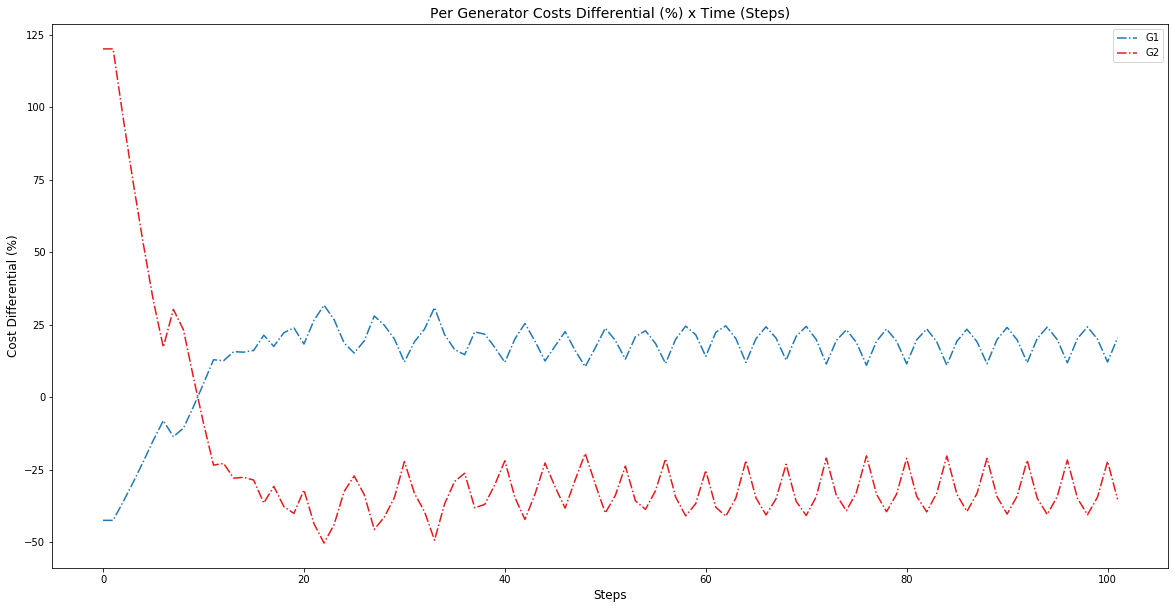

In [14]:
# # Show the last episode ran during training
from learning.learning_state import LearningState
plotAll(LearningState().episode.electricalSystem.systemHistory)

In [15]:
from learning.learning_state import LearningState
import numpy as np

rewList = LearningState().model.cummRewardList

In [16]:
LearningState().model.allRewards

[[{'cost': 0.07844116566292587,
   'output': 0.8967854258985096,
   'total': 0.07034489415700253},
  {'cost': 0.07232421785443696,
   'output': 0.7374188227836805,
   'total': 0.05333323958896936},
  {'cost': 0.21659386436046124,
   'output': 0.1275438027310553,
   'total': 0.02762520510874762},
  {'cost': 0.31440931019614976,
   'output': 0.00040320607061007684,
   'total': 0.0001267717425274143},
  {'cost': 0.2474700533938987,
   'output': 0.02939296032685004,
   'total': 0.007273877461490325},
  {'cost': 0.20087865176101105,
   'output': 0.26263585768839653,
   'total': 0.05275793699654186},
  {'cost': 0.47101150096563676,
   'output': 3.5816839861258304e-08,
   'total': 1.6870143502897123e-08},
  {'cost': 0.4822674853099923,
   'output': 4.514071763327821e-09,
   'total': 2.176990037808951e-09},
  {'cost': 0.08861965693235777,
   'output': 0.9157152900642053,
   'total': 0.08115037485320435},
  {'cost': 0.052309530568280804,
   'output': 0.046856389302699766,
   'total': 0.00245103

TypeError: float() argument must be a string or a number, not 'dict'

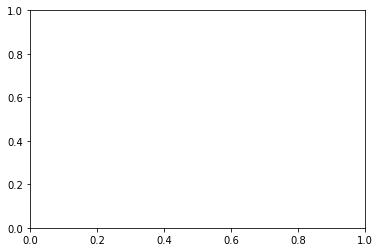

In [17]:
allRewards = LearningState().model.allRewards


for r in allRewards:
    plt.figure()
    plt.scatter(range(len(r)), r)
# sum(rewards)

In [ ]:
plt.scatter(range(len(rewList)), rewList)

In [ ]:
from plots.plot_constants import COLOR_PALETTE, FONT_SIZES

history = electricalSystem.systemHistory
# Get series to be plotted
stepsSeries = history.steps
loads = history.loads
totalLoadSeries = history.totalLoad
generators = history.generators
totalPowerSeries = history.totalPower

plt.figure(0)

# Declare colors to be used
colorTotalLoad = COLOR_PALETTE[0]
colorTotalPower = COLOR_PALETTE[1]
colorsIndividualNodes = COLOR_PALETTE[3:]

# Plot total power/load data
plt.plot(stepsSeries, totalLoadSeries, color=colorTotalLoad)
plt.plot(stepsSeries, totalPowerSeries, color=colorTotalPower)
legendFields = ['Total Load', 'Total Power']

# Multiple scenarios involve a single load, so we make it optional to plot that single load
if(False):
    for idx, loadId in enumerate(loads):
        # Since num loads is variable, colors may wrap around the palette
        loadColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
        loadLegend = loadId
        loadSeries = loads[loadId]
        plt.plot(stepsSeries, loadSeries, color=loadColor, linestyle='--')
        legendFields.append(loadLegend)

for idx, generatorId in enumerate(generators):
    # Since num generators is variable, colors may wrap around the palette
    generatorColor = colorsIndividualNodes[idx % len(colorsIndividualNodes)]
    generatorLegend = generatorId
    generatorSeries = generators[generatorId]
    plt.plot(stepsSeries, generatorSeries, color=generatorColor)
    legendFields.append(generatorLegend)
    

summedPow = [x + y for x, y in zip(generators.get('G1'), generators.get('G2'))]
plt.plot(stepsSeries, summedPow, color=COLOR_PALETTE[2])
legendFields.append("Summed Pow")


plt.legend(legendFields)
plt.xlabel('Steps', fontsize=FONT_SIZES['AXIS_LABEL'])
plt.ylabel('Power (pu)', fontsize=FONT_SIZES['AXIS_LABEL'])

plt.title('System Power (pu) x Time (Steps)', fontsize=FONT_SIZES['TITLE'])

plt.show()